In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [17]:
all_data = pd.read_csv("vgg16_cifar10.csv")
all_data.head()

,run,operation,started,time,status,label,blocker,data_location,dataset,gpu,...,Sparsity,alignment_score,best_post_acc,best_post_loss,best_pre_acc,best_pre_loss,immediate_post_acc,immediate_post_loss,Accuracy/preprune,Loss/preprune
0,1eb84d0b,main.py,2022-06-21 10:55:23,1:35:38,error,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.5500,0.175290,0.9425,0.271525,0.9352,0.31292,0.9244,0.372921,NaN,NaN
1,e4b49d81,main.py,2022-06-21 10:55:22,1:34:47,error,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.9763,8.690473,0.8114,0.563873,0.9352,0.31292,0.1000,2.318487,NaN,NaN
2,b175f727,main.py,2022-06-21 10:55:22,1:35:30,error,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.9803,8.718378,0.7603,0.699414,0.9352,0.31292,0.1000,2.315190,NaN,NaN
3,a8ba2054,main.py,2022-06-21 10:55:21,1:06:28,error,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.9847,8.758571,0.7090,0.817911,0.9352,0.31292,0.1000,2.312724,NaN,NaN
4,df2d5bc3,main.py,2022-06-21 10:55:21,0:54:11,error,vgg16_cifar10,none,~/torch_subspace/data/,cifar10,cuda,...,0.9895,8.647780,0.1000,2.302497,0.9352,0.31292,0.1000,2.312269,NaN,NaN


In [18]:
alignment_variance = pd.read_csv("sid_guild.csv")
alignment_variance = alignment_variance[alignment_variance["pruner"] == "alignment_variance"]
all_data = pd.concat([all_data, alignment_variance], axis="index", ignore_index=True)

In [19]:
all_data = all_data[["blocker", "pruner", "best_pre_acc", "best_post_acc", "Sparsity", "immediate_post_acc"]]
all_data["acc_drop"] = all_data["best_pre_acc"] - all_data["best_post_acc"]
all_data.head()

,blocker,pruner,best_pre_acc,best_post_acc,Sparsity,immediate_post_acc,acc_drop
0,none,relative_layer_error,0.9352,0.9425,0.5500,0.9244,-0.0073
1,none,relative_layer_error,0.9352,0.8114,0.9763,0.1000,0.1238
2,none,relative_layer_error,0.9352,0.7603,0.9803,0.1000,0.1749
3,none,relative_layer_error,0.9352,0.7090,0.9847,0.1000,0.2262
4,none,relative_layer_error,0.9352,0.1000,0.9895,0.1000,0.8352


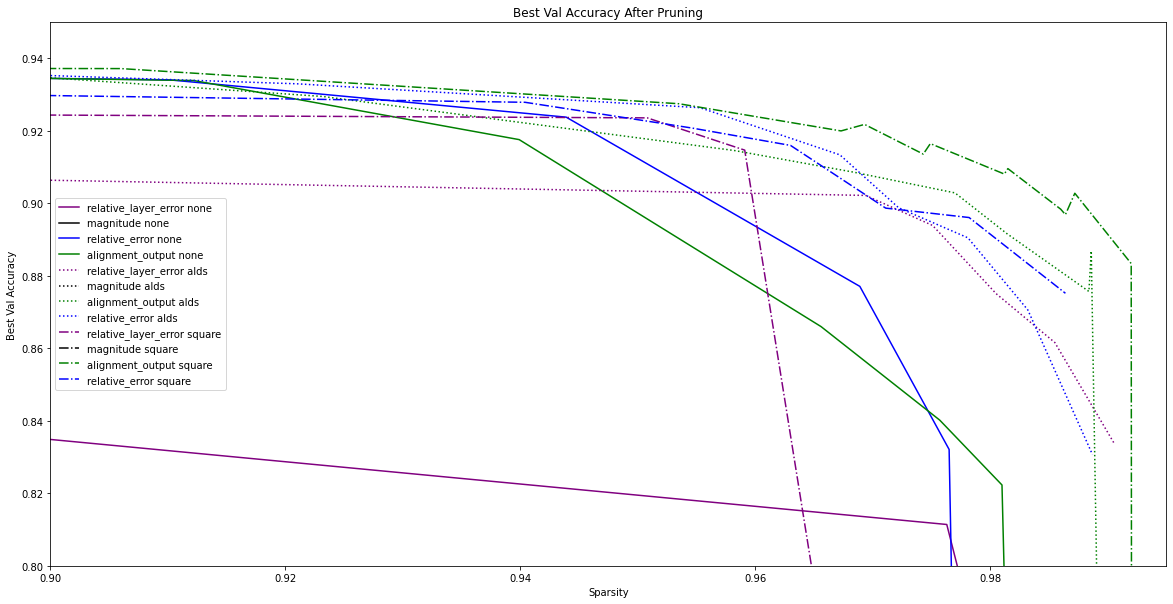

In [20]:
data = all_data[
    (all_data["pruner"] != "alignment_output_sampling") &
    (all_data["pruner"] != "alignment_output_sampling_proportional")
]
# data = all_data[all_data["blocker"] == "square"]
data = all_data[
    (all_data["pruner"] != "alignment_output_sampling_proportional") &
    (all_data["pruner"] != "alignment_output_sampling")
]
plt.figure(figsize=(20, 10))
blocker_styles = {
    "none": "-",
    "alds": ":",
    "true_alds": "--",
    "square": "-.",
}
pruner_colors = {
    "magnitude": "black",
    "relative_error": "blue",
    "relative_layer_error": "purple",
    "alignment_output": "green",
    "alignment_variance": "purple",
    "alignment_output_sampling": "red",
    # "alignment_output_sampling_proportional": "black"
}
for blocker in data["blocker"].unique():
    b = data[data["blocker"] == blocker]
    for pruner in b["pruner"].unique():
        p = b[b["pruner"] == pruner].sort_values(by="Sparsity")
        color = "red" if blocker == "true_alds" else pruner_colors[pruner]
        plt.plot(
            p["Sparsity"],
            p["best_post_acc"],
            label=f"{pruner} {blocker}",
            linestyle=blocker_styles[blocker],
            color=color
        )
plt.legend()
plt.xlabel("Sparsity")
plt.ylabel("Best Val Accuracy")
plt.ylim(0.8, 0.95)
# plt.xlim(0.9, 0.995)
plt.title("Best Val Accuracy After Pruning")
plt.show()
